# Text Classification, Lab 2: Building a model with K-Train

## ⚡️ Make a Copy

Save a copy of this notebook in your Google Drive before continuing. Be sure to edit your own copy, not the original notebook.

## About this lab

The first part of this lab is identical to Lab 1, and you should be able to step through it easily.

We continue now with the goal of building an inference model for predicting whether or not a document is about "healthy living." We will use the K-Train library to do this.

## About the final project


Recall that you are working toward a final project. After completing this lab, you will want to go the extra mile and explore ways to tweak and improve your model. See the final project description for further details on what is expected.

## Imports

We're going to be using Google's Tensorflow package:
https://www.tensorflow.org/tutorials

We're using an API wrapper for Tensorflow called ktrain. It's absolutely fabulous because it really abstracts the whole deep learning process into a workflow so easy, even a computational social scientist can do it:
https://github.com/amaiya/ktrain

In [ ]:
# ! pip uninstall ktrain

! pip install ktrain==0.32

In [ ]:
! pip install "tensorflow<2.12"
! pip install Seaborn

In [40]:
import os
import ktrain
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

BATCH_SIZE = 32
SAMPLE_COUNT = 10000

## Mount Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Set your google colab runtime to use GPU, a must for deep learning!

Runtime > Change Runtime Type > GPU

The following code snippet will show you GPU information for your runtime.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

## Load the data

The data file should be in your Google Drive from Lab 1.

In [ ]:
path = "drive/MyDrive/Text_CUB/P1_Final/"
#for local run
path = './'
file = "news_category_trainingdata.json"
news = pd.read_json(path + file)

## Inspect the data

In [30]:
news.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [31]:
news.info()

news.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 10.7+ MB


category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

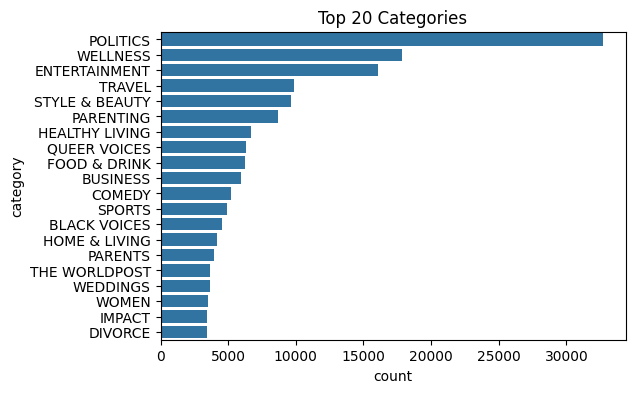

In [32]:
news_cat_count =news["category"].value_counts().head(20)

type(news_cat_count)

f = plt.figure(figsize=(6,4))
sns.barplot(x = 'count',
            y = 'category',
            data =news_cat_count.reset_index().rename(columns = {'index':'category','category':'count'})
            ).set(title='Top 20 Categories')
plt.show()

## Prepare the data

Most machine learning tools in Python accept one field/column/string. So we have to merge our two text column. Let's separate it with a space.

In [33]:
news['combined_text'] = news['headline'] + ' ' + news['short_description']

The first thing we need to do is prepare the data. Specifically, we have a categorical column that we want to turn into a "is this article healthy living?" column. That is, when an article is about healthy living, it should have a 1, when it's anything else, it should be a 0.

In [34]:
well_cat = ['HEALTHY LIVING', 'WELLNESS']
news['H&W'] = np.where((news['category'].isin(well_cat)), 1, 0)
news.head()


,category,headline,authors,link,short_description,date,combined_text,H&W
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,0


In [35]:
news['H&W'].describe()

count    200853.000000
mean          0.122084
std           0.327384
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: H&W, dtype: float64

In [36]:
news['H&W'].value_counts()

0    176332
1     24521
Name: H&W, dtype: int64

## Balance the data

To create a balanced data set that includes all of the health living articles, set sample_amount to the total number of those articles.

In Lab 1, you balanced the data for the full set of healthy living articles. In the interest of getting through Lab 2 more quickly (in terms of training time for the model), we will use a smaller sample, of just 1000 articles per class. After completing the lab, consider increasing the sample size to see if you can get improvements on the model performance. Of course, be prepared for longer training times when you do that.

In [41]:
# We have replaced the sample count with a smaller number in order to expedite
# the completion of the lab. For your final project, you will want to use the
# full balanced document set which is determined by this commented line:
#sample_amount =  len(news[news["healthy"] == 1]) # the total number of healthy living articles



wellness = news[news['H&W'] == 1].sample(n=SAMPLE_COUNT)
not_wellness = news[news['H&W'] == 0].sample(n=SAMPLE_COUNT)

In [42]:
news_sample = pd.concat([wellness,not_wellness])

In [43]:
news_sample.describe()

,H&W
count,20000.000000
mean,0.500000
std,0.500013
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [44]:
news_sample.drop(['category', 'headline', 'authors', 'link', 'short_description', 'date'], axis=1, inplace=True)


## Clean the data

In [45]:
news_sample.head()

,combined_text,H&W
121596,The Best City For Parks Is...,1
156024,Being Completely Normal Living With a Mental I...,1
172548,Feel Like a Thanksgiving Turkey? Get Unstuffed...,1
198036,Why Do Cancer Patients Die From Blood Clots? I...,1
144944,"Inspiration I'm angry, I'm grateful, I'm sad a...",1


In [46]:
import re
import string
import nltk
import pandas as pd
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# retrieve english stop words
stop_words = set(stopwords.words('english'))

# Converts text to lower case
def convert_to_lowercase(text):
    if pd.isna(text):
        return text
    if isinstance(text, str):
        return text.lower()
    return text

# Remove all punctuation from the text
def remove_punctuation(text):
    if pd.isna(text):
        return text
    text = re.sub(f'[{string.punctuation}]', '', text)
    return text

# Removes all numbers from the text
def remove_numbers(text):
    if pd.isna(text):
        return text
    text = re.sub(r'\d+', '', text)
    return text

# Text segmentation, then remove the length of 2 or less and the single word and stop word
def remove_short_words_and_stop_words(text):
    if pd.isna(text):
        return text
    words = word_tokenize(text)
    words = [word for word in words if len(word) > 2 and word not in stop_words]
    cleaned_text = ' '.join(words)
    return cleaned_text

# Replace two or more consecutive Spaces with a single space
def remove_multiple_spaces(text):
    if pd.isna(text):
        return text
    cleaned_text = re.sub(r' {2,}', ' ', text)
    return cleaned_text

# Remove urls
def remove_urls(text):
    if pd.isna(text):
        return text
    url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(url_pattern, '', text)

# Remove htmls
def remove_html(text):
    if pd.isna(text):
        return text
    html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
    return re.sub(html_entities, '', text)

# Remove @ and #
def remove_tags(text):
    if pd.isna(text):
        return text
    tag_pattern = r'@([a-z0-9]+)|#'
    return re.sub(tag_pattern, '', text)


def preprocess_text(text):
    if pd.isna(text):
        return text
    cleaned_text = re.sub(r'[^a-zA-Z\d\s]+', '',text)
    word_list = []
    for each_word in cleaned_text.split(' '):
        word_list.append((each_word).lower())
    word_list = [
        WordNetLemmatizer().lemmatize(each_word.strip()) for each_word in word_list
        if each_word not in stop_words and each_word.strip() != ''
    ]
    return " ".join(word_list)



def clean_text(df, col):
    df[col] = df[col].apply(convert_to_lowercase)
    df[col] = df[col].apply(remove_urls)
    df[col] = df[col].apply(remove_html)
    df[col] = df[col].apply(remove_tags)
    df[col] = df[col].apply(remove_numbers)
    df[col] = df[col].apply(remove_short_words_and_stop_words)
    df[col] = df[col].apply(remove_multiple_spaces) 
    df[col] = df[col].apply(preprocess_text)
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SEELE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SEELE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SEELE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
news_sample = clean_text(news_sample, 'combined_text')

In [48]:
news_sample.head()

,combined_text,H&W
121596,best city park,1
156024,completely normal living mental illness one de...,1
172548,feel like thanksgiving turkey get unstuffed ho...,1
198036,cancer patient die blood clot cancer patient c...,1
144944,inspiration angry grateful sad cry happy survi...,1


# On to Lab 2: Test, Tune and Save Models

Here, you will tune and train a predictor model for classifying healthy-living articles. After completing this lab, complete the Lab Quiz by entering your precision and recall values from the validation report for both the negative and positive classes.

In [49]:
target_names = ['not wellness','wellness']

---

### Experimenting with different transformers

For purposes of this lab, we are using the **distilbert-base-uncased** transformer model. Other models you might try for your final project include:

 * roberta-base
 * bert-base-uncased
 * distilroberta-base

See all the models here: https://huggingface.co/transformers/pretrained_models.html

Some work, some dont, try at your own risk.

---

In [ ]:
# https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-04-text-classification.ipynb


ktrain.text.print_text_classifiers()


In [57]:
# release GPU memory for next training
ktrain.release_gpu_memory()
train, val, preprocess = ktrain.text.texts_from_df(
    news_sample,
    "combined_text",
    label_columns=["H&W"],
    val_df=None,
    max_features=20000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode= "distilbert",
    verbose=1
)

['not_H&W', 'H&W']
        not_H&W  H&W
38992       1.0  0.0
95617       1.0  0.0
48816       0.0  1.0
134387      0.0  1.0
3322        1.0  0.0
['not_H&W', 'H&W']
        not_H&W  H&W
128280      0.0  1.0
24982       1.0  0.0
2965        1.0  0.0
164196      0.0  1.0
93432       1.0  0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 18
	95percentile : 30
	99percentile : 36


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 18
	95percentile : 30
	99percentile : 36


In [58]:
model = ktrain.text.text_classifier('distilbert', train, preproc=preprocess)
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=BATCH_SIZE)

Is Multi-Label? False
maxlen is 512
done.


In [ ]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
562/562 [==============================] - 27000s 48s/step - loss: 0.6323 - accuracy: 0.6256
Epoch 2/6
562/562 [==============================] - 29836s 53s/step - loss: 0.3039 - accuracy: 0.8794
Epoch 3/6
 93/562 [===>..........................] - ETA: 6:44:46 - loss: 0.2334 - accuracy: 0.9101

In [ ]:
learner.lr_plot(suggest = True)

# Hyperparameter Tuning

Now, use the tuned learner to train the best model.

Here, we define a limit of 10 epochs, but in reality, this should stop much sooner due to early stopping.

In [ ]:
history=learner.autofit(
    1e-3,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)

In [ ]:
learner.model.summary()

In [ ]:
validation = learner.validate(val_data=val, print_report=True)

## Model B: fasttext

In the first model, the base model used was DistilBERT, and the text was preprocessed accordingly.

During inference, DistilBERT is 60% faster than BERT. DistilBERT has 44M fewer parameters and in total is 40% smaller than BERT. However, the original BERT model is slightly more performant, and we can test if that performance is meaningful in this case.

In [50]:
# release GPU memory for next training
ktrain.release_gpu_memory()
train, val, preprocess = ktrain.text.texts_from_df(
    news_sample,
    "combined_text",
    label_columns=["H&W"],
    val_df=None,
    max_features=20000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode= "standard",
    verbose=1
)

['not_H&W', 'H&W']
        not_H&W  H&W
159272      0.0  1.0
178940      0.0  1.0
190803      0.0  1.0
69579       1.0  0.0
146937      1.0  0.0
['not_H&W', 'H&W']
        not_H&W  H&W
153946      1.0  0.0
74538       1.0  0.0
145176      1.0  0.0
185040      0.0  1.0
159970      0.0  1.0
language: en
Word Counts: 28244
Nrows: 18000
18000 train sequences
train sequence lengths:
	mean : 18
	95percentile : 29
	99percentile : 35
x_train shape: (18000,512)
y_train shape: (18000, 2)
Is Multi-Label? False
2000 test sequences
test sequence lengths:
	mean : 17
	95percentile : 28
	99percentile : 33
x_test shape: (2000,512)
y_test shape: (2000, 2)


In [51]:
model = ktrain.text.text_classifier('fasttext', train, preproc=preprocess)
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=BATCH_SIZE)

Is Multi-Label? False
compiling word ID features...
maxlen is 512
done.


In [52]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
563/563 [==============================] - 14s 23ms/step - loss: 0.9778 - accuracy: 0.5087
Epoch 2/6
563/563 [==============================] - 14s 25ms/step - loss: 0.9689 - accuracy: 0.5127
Epoch 3/6
563/563 [==============================] - 14s 24ms/step - loss: 0.8265 - accuracy: 0.5597
Epoch 4/6
563/563 [==============================] - 13s 24ms/step - loss: 0.5020 - accuracy: 0.7624
Epoch 5/6
563/563 [==============================] - 15s 26ms/step - loss: 0.6288 - accuracy: 0.6202
Epoch 6/6
563/563 [==============================] - 13s 24ms/step - loss: 0.8168 - accuracy: 0.5038


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 7.66E-04
	Min numerical gradient (purple): 8.82E-04
	Min loss divided by 10 (omitted from plot): 3.68E-03


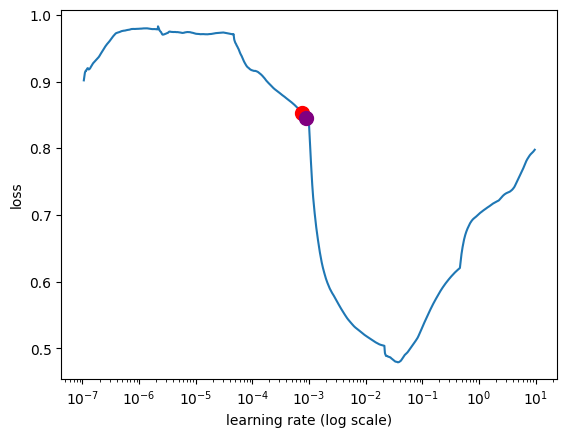

In [53]:
learner.lr_plot(suggest = True)

In [54]:
history=learner.autofit(
    7.66E-04,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.000766...
Epoch 1/10
563/563 [==============================] - 17s 29ms/step - loss: 0.7771 - accuracy: 0.5968 - val_loss: 0.5196 - val_accuracy: 0.8220
Epoch 2/10
563/563 [==============================] - 16s 28ms/step - loss: 0.5412 - accuracy: 0.7368 - val_loss: 0.3693 - val_accuracy: 0.8545
Epoch 3/10
563/563 [==============================] - 16s 28ms/step - loss: 0.4288 - accuracy: 0.8067 - val_loss: 0.3276 - val_accuracy: 0.8750
Epoch 4/10
563/563 [==============================] - 16s 28ms/step - loss: 0.3554 - accuracy: 0.8438 - val_loss: 0.3084 - val_accuracy: 0.8815
Epoch 5/10
563/563 [==============================] - 15s 26ms/step - loss: 0.3015 - accuracy: 0.8762 - val_loss: 0.2996 - val_accuracy: 0.8790
Epoch 6/10
563/563 [==============================] - 15s 26ms/step - loss: 0.2567 - accuracy: 0.8988 - val_loss: 0.3009 - val_accuracy: 0.8790
Epoch 6: early stopping
Weights from best epoch have b

In [ ]:
validation = learner.validate(val_data=val, print_report=True)

## Predictor

Get the predictor

In [55]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

Optionally, uncomment this code to save the predictor and reload it later. Note, the saved models can be quite large and may quickly use up space on your Google Drive.

In [ ]:
#predictor.save("drive/MyDrive/MSDSTextClassification_Lab2.healthy_living")

63/63 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1038
           1       0.87      0.88      0.87       962

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



Let's go ahead and make a little set of test documents to check out

In [ ]:
test_docs = [
'Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.'
             ]

In [ ]:
for i, text in enumerate(test_docs):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy is %s' % probs[1])
  print(text)

*These* are pretty obvious examples, but it works exactly as expected!

In [ ]:
predictor.explain('Diversity is the key to a healthy society. Here is what we need to do to make america a more equitable place to live for all.')

But you can see, this algorithm is far from perfect. Here you can see that it's probably got too high of an emphasis on the word "healthy."

So what would I do next? Well, given that it's over reacting to worrds like health and equitable, I'd try introducing more negative examples into the data, times where healthy is used outside of health and wellness news. We can do this by changing our sample from 50/50 to something like 20/80, but of course, the more documents we process, the longer this model is going to take to make!